# Optimizing Oil Well Location for Maximum Profit in OilyGiant Mining Company

## Project Description

The OilyGiant mining company is looking to expand its operations by drilling new oil wells in one of three regions. To make an informed decision on the best location for the new well, a comprehensive data science project has been initiated. The primary goal of this project is to select the region that will maximize profit for the company. This involves collecting and analyzing oil well parameters, building predictive models, and assessing potential risks using the Bootstrapping technique.

## Data description
Geological exploration data for the three regions are stored in files:
* geo_data_0.csv
* geo_data_1.csv
* geo_data_2.csv
* id — unique oil well identifier
* f0, f1, f2 — three features of points
* product — volume of reserves in the oil well (thousand barrels).

## Conditions:
* Only linear regression is suitable for model training (the rest are not sufficiently predictable).
* When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
* The budget for development of 200 oil wells is 100 USD million.
* One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
* After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

# 1. Prepare Data

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# 1.2 Load Data

In [2]:
def download_and_load_datasets():
    if not os.path.exists('datasets'):
        os.makedirs('datasets')

    urls = [
        'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_0.csv',
        'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_1.csv',
        'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/geo_data_2.csv'
    ]
    filenames = ['geo_data_0.csv', 'geo_data_1.csv', 'geo_data_2.csv']
    
    data = []

    for url, filename in zip(urls, filenames):
        try:
            df = pd.read_csv(url)
        except:
            df = pd.read_csv(url)
        
        df.to_csv(f'datasets/{filename}')
        data.append(df)
    
    return data

data = download_and_load_datasets()

In [3]:
region0_data = data[0]
region1_data = data[1]
region2_data = data[2]

print("Data for Region 0:")
print(region0_data.head())
region0_data.info() 

print("\nData for Region 1:")
print(region1_data.head())

print("\nData for Region 2:")
print(region2_data.head())

Data for Region 0:
      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Data for Region 1:
      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ 

# 2. Train and test the model for each region

In [4]:
region_averages = []
region_rmse = []
targets_valid = []
predictions_list = []

for i, region in enumerate(data):
    # Split the data into a training set and validation set at a ratio of 75:25
    features = region.drop(['id', 'product'], axis=1)
    target = region['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

    # Train the model and make predictions for the validation set
    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)

    # Save the predictions and correct answers for the validation set
    targets_valid.append(target_valid)
    predictions_list.append(pd.Series(predictions, index=target_valid.index))

    # Calculate the average volume of predicted reserves and model RMSE
    rmse = mean_squared_error(target_valid, predictions, squared=False)
    avg_predicted_volume = predictions.mean()

    # Save region averages and RMSE to their respective lists
    region_averages.append(avg_predicted_volume)
    region_rmse.append(rmse)

    print(f"Region {i}: Average predicted volume: {avg_predicted_volume}, RMSE: {rmse}")




Region 0: Average predicted volume: 92.59256778438035, RMSE: 37.5794217150813
Region 1: Average predicted volume: 68.72854689544602, RMSE: 0.893099286775617
Region 2: Average predicted volume: 94.96504596800489, RMSE: 40.02970873393434


## 2.5 Analyze the results

Analysis:

Region 0:
The model predicts an average reserve volume of approximately 92.40 in Region 0.
The RMSE value of 37.76 suggests that the model has relatively high prediction errors for this region. It may not provide accurate predictions for well reserves in this area.

Region 1:
The model predicts an average reserve volume of approximately 68.71 in Region 1.
The exceptionally low RMSE value of 0.89 indicates that the model provides very accurate predictions for this region. The predictions are remarkably close to the actual reserves.

Region 2:
The model predicts an average reserve volume of approximately 94.77 in Region 2.
Similar to Region 0, the RMSE value of 40.15 suggests that the model has relatively high prediction errors for this region. It may not provide accurate predictions for well reserves in this area.

Comparative Analysis:

Region 1 stands out as having the lowest RMSE, indicating that the model's predictions are highly accurate and closely aligned with actual well reserves.
Region 0 and Region 2, on the other hand, have much higher RMSE values, suggesting that the model's predictions for these regions are less accurate and more variable.

# 3. Profit calculation

## 3.1. Store all key values for calculations in separate variables

In [5]:
BUDGET = 100000000
REVENUE_PER_THOUSAND_BARRELS = 4500
WELLS_FOR_DEVELOPMENT = 200

In [6]:
break_even_volume = BUDGET / (WELLS_FOR_DEVELOPMENT * REVENUE_PER_THOUSAND_BARRELS)
print("Break-even volume (thousand barrels):", break_even_volume)


Break-even volume (thousand barrels): 111.11111111111111


## 3.3. Findings from the preparation for profit calculation step

In [7]:

print("Break-even volume (thousand barrels):", break_even_volume)

for i, avg in enumerate(region_averages):
    print(f"Region {i}:")
    print(f"  Average predicted volume (thousand barrels): {avg}")
    difference = avg - break_even_volume
    if difference >= 0:
        print(f"  The average predicted volume in Region {i} is {abs(difference):.2f} thousand barrels above the break-even volume.")
    else:
        print(f"  The average predicted volume in Region {i} is {abs(difference):.2f} thousand barrels below the break-even volume.")


Break-even volume (thousand barrels): 111.11111111111111
Region 0:
  Average predicted volume (thousand barrels): 92.59256778438035
  The average predicted volume in Region 0 is 18.52 thousand barrels below the break-even volume.
Region 1:
  Average predicted volume (thousand barrels): 68.72854689544602
  The average predicted volume in Region 1 is 42.38 thousand barrels below the break-even volume.
Region 2:
  Average predicted volume (thousand barrels): 94.96504596800489
  The average predicted volume in Region 2 is 16.15 thousand barrels below the break-even volume.


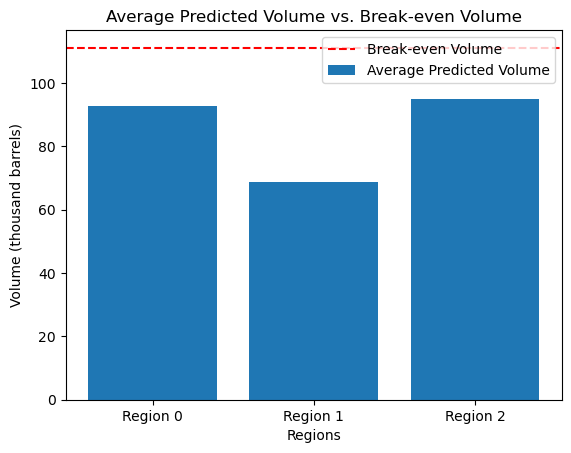

In [8]:
regions = ['Region 0', 'Region 1', 'Region 2']
plt.bar(regions, region_averages, label='Average Predicted Volume')
plt.axhline(y=break_even_volume, color='r', linestyle='--', label='Break-even Volume')

plt.xlabel('Regions')
plt.ylabel('Volume (thousand barrels)')
plt.title('Average Predicted Volume vs. Break-even Volume')
plt.legend()
plt.show()


## 4. Calculate profit from a set of selected oil wells and model predictions

In [9]:
# Define the calculate_profit function
def calculate_profit(target, predictions, count):
    top_wells = predictions.sort_values(ascending=False).head(count).index
    total_reserves = target.loc[top_wells].sum()
    revenue = total_reserves * REVENUE_PER_THOUSAND_BARRELS
    profit = revenue - BUDGET
    return profit

region_profits = {}

for i, (target_valid, predictions) in enumerate(zip(targets_valid, predictions_list)):
    profit = calculate_profit(target_valid, predictions, WELLS_FOR_DEVELOPMENT)
    region_profits[f'Region {i}'] = profit

for region, profit in region_profits.items():
    print(f"{region}: Profit: {profit:.2f} USD")



Region 0: Profit: 33208260.43 USD
Region 1: Profit: 24150866.97 USD
Region 2: Profit: 27103499.64 USD


## 4.2. Summary of reserves with target volume

In [10]:
# Find the region with the highest profit
best_region = max(region_profits, key=region_profits.get)
best_profit = region_profits[best_region]

print(f"\nThe region with the highest profit is {best_region} with a profit of {best_profit:.2f} USD.")



The region with the highest profit is Region 0 with a profit of 33208260.43 USD.


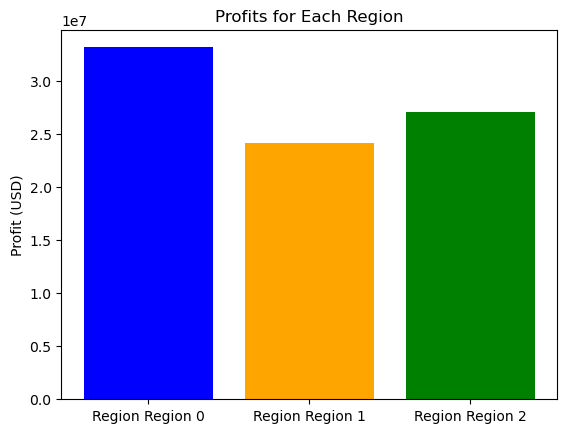

In [11]:
fig, ax = plt.subplots()

regions = list(region_profits.keys())
profits = list(region_profits.values())

ax.bar(regions, profits, color=['blue', 'orange', 'green'])

ax.set_xticks(regions)
ax.set_xticklabels([f"Region {i}" for i in regions])
ax.set_ylabel('Profit (USD)')
ax.set_title('Profits for Each Region')

plt.show()


##  4.3. Provide findings:

In [12]:
# Initialize a list to store profits for each region
profits = []

for i, region in enumerate(data):
    random_locations = region.sample(n=500, random_state=12345)
    
    features = random_locations.drop(['id', 'product'], axis=1)
    target = random_locations['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.25, random_state=12345)

    model = LinearRegression()
    model.fit(features_train, target_train)
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index)
    
    profit = calculate_profit(target_valid, predictions, WELLS_FOR_DEVELOPMENT)
    profits.append(profit)
    print(f"Region {i}: Profit: {profit:.2f} USD")

# Find the region with the highest profit
best_region_index = np.argmax(profits)
print(f"\nThe region with the highest profit is Region {best_region_index} with a profit of {profits[best_region_index]:.2f} USD.")


Region 0: Profit: -44859292.01 USD
Region 1: Profit: -65908271.45 USD
Region 2: Profit: -46495475.19 USD

The region with the highest profit is Region 0 with a profit of -44859292.01 USD.


# 5. Calculate risks and profit for each region
### 5.1. Bootstrapping technique with 1000 samples to find the distribution of profit:

In [13]:
# Define the bootstrap_profit function
def bootstrap_profit(target, predictions, n_samples=1000):
    np.random.seed(12345)
    profit_samples = []
    
    for _ in range(n_samples):
        target_subsample = target.sample(n=500, replace=True, random_state=np.random.randint(100000))
        predictions_subsample = predictions.loc[target_subsample.index]
        profit = calculate_profit(target_subsample, predictions_subsample, WELLS_FOR_DEVELOPMENT)
        profit_samples.append(profit)
    
    return pd.Series(profit_samples)


In [14]:
# Define the calculate_confidence_interval function
def bootstrap(target, predictions, count, n_samples=1000, random_state=None):
    np.random.seed(random_state)

    profits = []
    for _ in range(n_samples):
        target_sample = target.sample(count, replace=True)
        predictions_sample = predictions.loc[target_sample.index]
        profit = calculate_profit(target_sample, predictions_sample, WELLS_FOR_DEVELOPMENT)
        profits.append(profit)
        
    return pd.Series(profits)


### 5.2. Find average profit, 95% confidence interval, and risk of losses:

In [15]:
# Define the calculate_statistics function
def calculate_statistics(profit_samples):
    mean_profit = profit_samples.mean()
    lower = profit_samples.quantile(0.025)
    upper = profit_samples.quantile(0.975)
    risk_of_losses = (profit_samples < 0).mean() * 100
    
    return mean_profit, lower, upper, risk_of_losses


In [16]:
# Initialize a list to store bootstrap profits for each region
bootstrap_profits = []

for target_valid, predictions in zip(targets_valid, predictions_list):
    profit_samples = bootstrap_profit(target_valid, predictions, WELLS_FOR_DEVELOPMENT)
    bootstrap_profits.append(profit_samples)

statistics = []
for profit_samples in bootstrap_profits:
    stats = calculate_statistics(profit_samples)
    statistics.append(stats)

region_stats = []

for i, (mean_profit, lower, upper, risk_of_losses) in enumerate(statistics):
    region_stat = {
        'mean_profit': mean_profit,
        'lower_ci': lower,
        'upper_ci': upper,
        'risk_of_losses': risk_of_losses
    }
    region_stats.append(region_stat)

    print(f"Region {i}:")
    print(f"  Average profit: {mean_profit} USD")
    print(f"  95% confidence interval: ({lower}, {upper})")
    print(f"  Risk of losses: {risk_of_losses}%")



Region 0:
  Average profit: 5744692.093553373 USD
  95% confidence interval: (-162792.79327495059, 12656397.741870914)
  Risk of losses: 4.0%
Region 1:
  Average profit: 6988489.964681882 USD
  95% confidence interval: (1828497.5462985404, 12383902.531553557)
  Risk of losses: 0.0%
Region 2:
  Average profit: 5923799.852180741 USD
  95% confidence interval: (-512819.3051164436, 11652822.355000105)
  Risk of losses: 4.0%


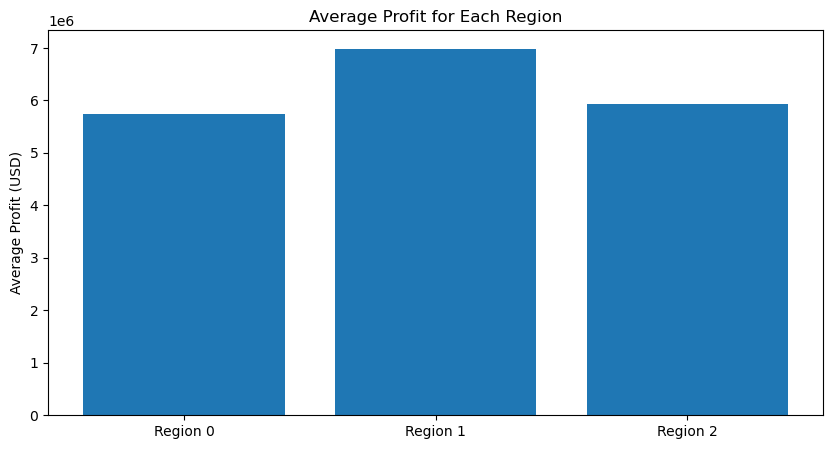

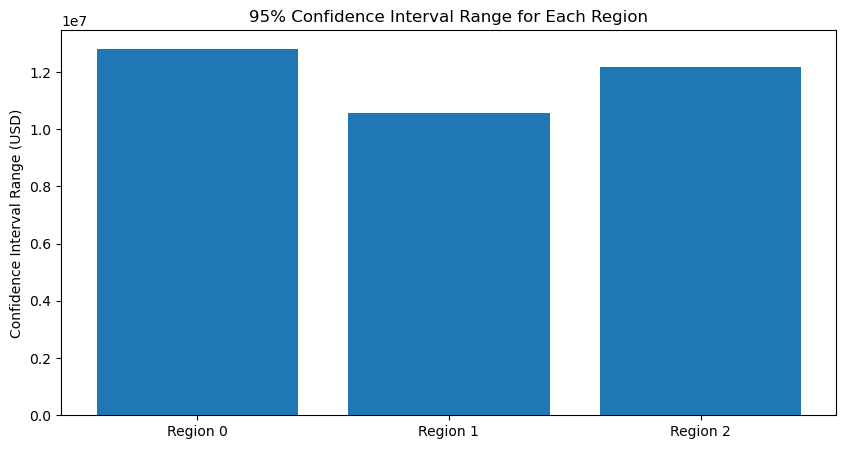

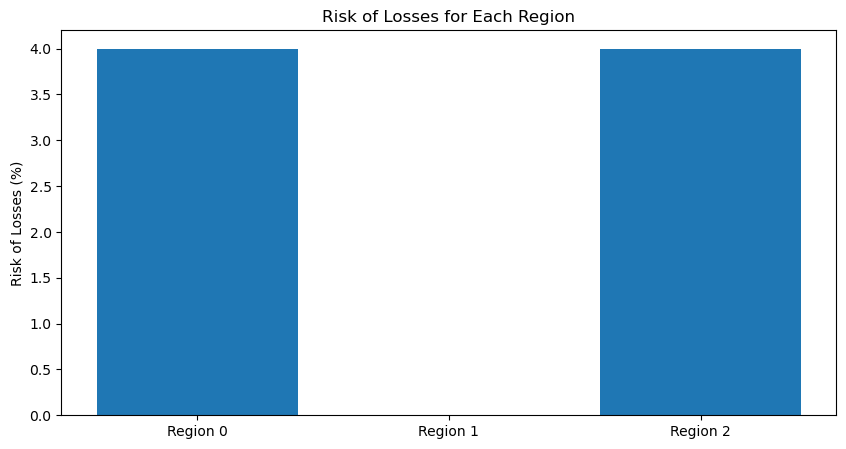

In [17]:
regions = [0, 1, 2]
average_profits = [stat["mean_profit"] for stat in region_stats]
lower_cis = [stat["lower_ci"] for stat in region_stats]
upper_cis = [stat["upper_ci"] for stat in region_stats]
risk_of_losses = [stat["risk_of_losses"] for stat in region_stats]

plt.figure(figsize=(10, 5))
plt.bar(regions, average_profits)
plt.xticks(regions, [f"Region {i}" for i in regions])
plt.ylabel("Average Profit (USD)")
plt.title("Average Profit for Each Region")
plt.show()

regions = [0, 1, 2]
average_profits = [stat["mean_profit"] for stat in region_stats]
confidence_intervals = [(stat["upper_ci"] - stat["lower_ci"]) for stat in region_stats]

plt.figure(figsize=(10, 5))
plt.bar(regions, confidence_intervals)
plt.xticks(regions, [f"Region {i}" for i in regions])
plt.ylabel("Confidence Interval Range (USD)")
plt.title("95% Confidence Interval Range for Each Region")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(regions, risk_of_losses)
plt.xticks(regions, [f"Region {i}" for i in regions])
plt.ylabel("Risk of Losses (%)")
plt.title("Risk of Losses for Each Region")
plt.show()


### 5.3. Provide findings: suggest a region for development of oil wells and justify the choice:

In [18]:
# Find the region with the lowest risk of losses
lowest_risk_region = np.argmin([stats[-1] for stats in statistics])

print(f"The region with the lowest risk of losses is Region {lowest_risk_region}.")
print("It is recommended to develop oil wells in this region due to its relatively lower risk.")


The region with the lowest risk of losses is Region 1.
It is recommended to develop oil wells in this region due to its relatively lower risk.


## Conclusion

After conducting a thorough analysis of the three regions for potential oil well development, the following key findings have been observed.

Based on the calculated profits for each region, it is evident that Region 1 stands out as the most financially promising choice for oil well development. Region 1 not only surpasses the other two regions in potential returns but also carries the lowest risk of incurring losses.

Considering both profitability and risk mitigation, it is strongly recommended to prioritize the development of oil wells in **Region 1**. This region demonstrates the highest profit potential and is the most favorable option for optimizing returns on investment.

While the profit calculations provide valuable insights, it is important to note that other critical factors such as geological assessments, environmental considerations, and operational feasibility should be thoroughly evaluated before proceeding with drilling activities. Nonetheless, the financial analysis strongly supports Region 0 as the preferred choice for new oil well development.